# Exploring Cloud Native Geospatial Data Formats with ERA5 Reanalysis Data


**Table of Contents**


1. [Introduction](#introduction)

2. [Cloud Native Data Formats](#cloud-native-data-formats)
    1. [SpatioTemporal Asset Catalog (STAC)](#stac)
    2. [Cloud Optimized GeoTIFFs (COGs)](#cogs)
    3. [Zarr](#zarr)
3. [Analyzing ERA5 Reanalysis Data](#analyzing-era5-reanalysis-data)
    1. [Parsing the STAC Catalog](#parsing-the-stac-catalog)
    2. [Reading and Processing Zarr Data](#reading-and-processing-zarr-data)
    3. [Visualizing Temperature Data](#visualizing-temperature-data)
4. [Conclusion](#conclusion)

## Setup

In [ ]:
%%time
import os
from pathlib import Path

data_dir = Path("data")

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # Mount drive to access data
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install uv
    !uv pip install --system \
        "adlfs>=2024.7.0" \
        "dask>=2024.11.2" \
        "fsspec>=2024.10.0" \
        "geopandas>=1.0.1" \
        "lonboard>=0.10.3" \
        "matplotlib>=3.9.2" \
        "planetary-computer>=1.0.0" \
        "pyarrow>=18.0.0" \
        "pystac-client>=0.8.5" \
        "xarray>=2024.11.0" \
        "zarr>=2.18.3" \
        "odc-stac>=0.3.10" \
        "rasterio>=1.4.2" \
        "rioxarray>=0.18.1" \
        "rasterstats>=0.20.0" \
        "numpy>=2.1.3"

    data_dir = Path("/content/drive/MyDrive/ingarss_workshop_2024")

    print("✅ Environment activated and data ready!")

> Note: In Colab, restart the runtime after installing the packages to ensure all the packages are loaded.

## Introduction

Geospatial data comes in many unique formats - including rasters, vectors, and point clouds. With the rapid growth of data sources like satellites, drones, and sensors, both the volume and complexity of geospatial data continues to increase exponentially.

To handle this data efficiently at scale, the community has developed Cloud Native data formats. These formats are specifically designed for cloud-based storage and processing.

### Key characteristics of Cloud Native Data Formats:

- Optimized for reading operations
    - Support for parallel reads from multiple processes/threads
    - Ability to read specific subsets of data without loading entire files
    - Fast metadata access in a single operation
    - Internal organization into tiles and chunks for efficient data access
 - Compatible with HTTP range requests for efficient access from cloud storage

**Please check this guide made by our amazing colleagues at Development Seed to learn more: https://guide.cloudnativegeo.org/**

## Cloud Native Data Formats

<img src="./images/cloud-native-formats.png" width="1000" height="500">

### SpatioTemporal Asset Catalog (STAC)

[**STAC Specification**](https://stacspec.org/en)


The SpatioTemporal Asset Catalog (STAC) is a standard for describing geospatial datasets in a consistent and searchable manner. It defines a common structure for cataloging spatial and temporal metadata, enabling easy discovery and access to geospatial assets.


STAC is organized into:

- **Catalogs**: Hierarchical grouping of Collections and Items.
- **Collections**: Groups of Items with shared metadata.
- **Items**: Individual geospatial assets with metadata.

STAC Index - https://stacindex.org/catalogs  
STAC Browser - https://radiantearth.github.io/stac-browser/#/  

<div style="display: flex; justify-content: space-between;">
    <div style="flex: 1; text-align: center; margin: 10px;">
        <h3>STAC Catalog</h3>
        <img src="./images/stac-catalog.png" style="width: 100%;">
    </div>
    <div style="flex: 1; text-align: center; margin: 10px;">
        <h3>STAC Collection</h3>
        <img src="./images/stac-collection.png" style="width: 100%;">
    </div>
    <div style="flex: 1; text-align: center; margin: 10px;">
        <h3>STAC Item</h3>
        <img src="./images/stac-item.png" style="width: 100%;">
    </div>
</div>

### Cloud Optimized GeoTIFFs (COGs)

[**COG Overview**](http://cogeo.org/)

Cloud Optimized GeoTIFFs (COGs) are GeoTIFF files structured in a way that makes it possible to efficiently stream subsets of imagery data, enabling fast and scalable data retrieval.

Key features of COGs:

- Internal tiling for efficient read access.
- Compatibility with HTTP range requests, so they can be stored in object storage & supports parallel/partial reads
- Pairs well with STAC to index & serve data
- Used to store raster data that represent a snapshot in time or limited assets. Satellite Imagery, DEM, etc

<div style="display: flex; justify-content: space-between;">
    <div style="flex: 1; text-align: center; margin: 10px;">
        <h3>COG Internal Directory</h3>
        <img src="./images/cog-internal-structure.png" style="width: 50%;">
    </div>
    <div style="flex: 1; text-align: center; margin: 10px;">
        <h3>COG Overviews</h3>
        <img src="./images/cog-overviews.png" style="width: 50%;">
    </div>
</div>

### Zarr

[**Zarr Documentation**](https://zarr.readthedocs.io/en/stable/)

Zarr is a format for the storage of chunked, compressed, N-dimensional arrays. It is ideal for large-scale, multi-dimensional datasets, such as weather data, climate models, and hyperspectral imagery.

Key features of Zarr:

- Supports chunking and compression for efficient storage and access.
- Metadata is store independently of the chunked data, facilitating efficient read access
- Supports parallel and partial reads, making it suitable for cloud storage and processing
- Used to store multi-dimensional rasters or datacubes. Weather data, Climate Models, Time-series data, Satellite Imagery, etc

<img src="./images/zarr.png" width="50%">

## Analyzing ERA5 Reanalysis Data

In this tutorial, we will:

- Parse a STAC catalog to discover data assets.
- Read ERA5 reanalysis data stored in Zarr format.
- Visualize the data and create animations.
- Create time-series plots and perform data analysis.

### Parsing the STAC Catalog

We will use the `pystac-client` library to interact with the STAC catalog and discover ERA5 reanalysis data.

#### ECMWF Reanalysis Data (ERA5)

ERA5 is the fifth generation ECMWF atmospheric reanalysis of the global climate covering the period from January 1940 to present. ERA5 is produced by the Copernicus Climate Change Service (C3S) at ECMWF.

ERA5 provides hourly estimates of a large number of atmospheric, land and oceanic climate variables. The data cover the Earth on a 31km grid and resolve the atmosphere using 137 levels from the surface up to a height of 80km. ERA5 includes information about uncertainties for all variables at reduced spatial and temporal resolutions.

<img src="./images/era5.png" width="25%">


In [1]:
import pystac_client
from datetime import datetime
import planetary_computer

# Initialize the STAC client
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/"
)

Let's explore a few collections available in the catalog.

In [6]:
# List the first 10 collections
for collection in list(catalog.get_collections())[:10]:
    print("Name: ", collection.title)
    print("ID: ", collection.id)
    print("-"*50)

Name:  Daymet Annual Puerto Rico
ID:  daymet-annual-pr
--------------------------------------------------
Name:  Daymet Daily Hawaii
ID:  daymet-daily-hi
--------------------------------------------------
Name:  USGS 3DEP Seamless DEMs
ID:  3dep-seamless
--------------------------------------------------
Name:  USGS 3DEP Lidar Digital Surface Model
ID:  3dep-lidar-dsm
--------------------------------------------------
Name:  Forest Inventory and Analysis
ID:  fia
--------------------------------------------------
Name:  Sentinel 1 Radiometrically Terrain Corrected (RTC)
ID:  sentinel-1-rtc
--------------------------------------------------
Name:  gridMET
ID:  gridmet
--------------------------------------------------
Name:  Daymet Annual North America
ID:  daymet-annual-na
--------------------------------------------------
Name:  Daymet Monthly North America
ID:  daymet-monthly-na
--------------------------------------------------
Name:  Daymet Annual Hawaii
ID:  daymet-annual-hi
-----

We are interested in the ERA5 collection. Lets look at the summary of the collection.

In [8]:
# Find the ERA5 collection
for collection in catalog.get_collections():
    if 'era5' in collection.id.lower():
        print("Name: ", collection.title)
        print("ID: ", collection.id)
        print("Summary: ", collection.summaries.to_dict())
        print("Assets: ", collection.assets)
        print("Extent: ", collection.extent.to_dict())
        print("Description: ", collection.description)
        print("-"*50)

Name:  ERA5 - PDS
ID:  era5-pds
Summary:  {'era5:kind': ['fc', 'an']}
Assets:  {'thumbnail': <Asset href=https://ai4edatasetspublicassets.blob.core.windows.net/assets/pc_thumbnails/era5-thumbnail.png>, 'geoparquet-items': <Asset href=abfs://items/era5-pds.parquet>}
Extent:  {'spatial': {'bbox': [[-180, -90, 180, 90]]}, 'temporal': {'interval': [['1979-01-01T00:00:00Z', None]]}}
Description:  ERA5 is the fifth generation ECMWF atmospheric reanalysis of the global climate
covering the period from January 1950 to present. ERA5 is produced by the
Copernicus Climate Change Service (C3S) at ECMWF.

Reanalysis combines model data with observations from across the world into a
globally complete and consistent dataset using the laws of physics. This
principle, called data assimilation, is based on the method used by numerical
weather prediction centres, where every so many hours (12 hours at ECMWF) a
previous forecast is combined with newly available observations in an optimal
way to produce a 

### Reading and Processing Zarr Data

We will query the ERA5 collection for data over India during the Kharif season (June to November 2020). We will filter the data based on a bounding box and temporal range.

In [23]:
import xarray as xr

# Bounding box for India [min_lon, min_lat, max_lon, max_lat]
india_bbox = [68.1, 6.5, 97.4, 37.1]

# Temporal range for Kharif Season
datetime_range = "2020-06-01/2020-11-30"

# Search parameters
search = catalog.search(
    collections=["era5-pds"],
    bbox=india_bbox,
    datetime=datetime_range,
    query={
        "era5:kind": {
            "eq": "an"  # Filter for analysis data only
        },
    }
)

# Fetch matching items
items = search.item_collection()
print(f"Number of matching items: {len(items)}")

Number of matching items: 6


Lets inspect the items from the collection

In [24]:
for item in items:
    print("Item ID:", item.id)
    print("Available assets:", list(item.assets.keys()))
    print("-"*50)


Item ID: era5-pds-2020-11-an
Available assets: ['surface_air_pressure', 'sea_surface_temperature', 'eastward_wind_at_10_metres', 'air_temperature_at_2_metres', 'eastward_wind_at_100_metres', 'northward_wind_at_10_metres', 'northward_wind_at_100_metres', 'air_pressure_at_mean_sea_level', 'dew_point_temperature_at_2_metres']
--------------------------------------------------
Item ID: era5-pds-2020-10-an
Available assets: ['surface_air_pressure', 'sea_surface_temperature', 'eastward_wind_at_10_metres', 'air_temperature_at_2_metres', 'eastward_wind_at_100_metres', 'northward_wind_at_10_metres', 'northward_wind_at_100_metres', 'air_pressure_at_mean_sea_level', 'dew_point_temperature_at_2_metres']
--------------------------------------------------
Item ID: era5-pds-2020-09-an
Available assets: ['surface_air_pressure', 'sea_surface_temperature', 'eastward_wind_at_10_metres', 'air_temperature_at_2_metres', 'eastward_wind_at_100_metres', 'northward_wind_at_10_metres', 'northward_wind_at_100_met

In [25]:
# Sort the items by month
items = list(reversed(items))



We will select the `air_temperature_at_2_metres` asset for further analysis.

In [28]:
# Select the June item and asset
june_item = items[0]
june_air_temp_asset = june_item.assets["air_temperature_at_2_metres"]

# Sign the asset URL for authentication
june_air_temp_asset = planetary_computer.sign(june_air_temp_asset)

# Display the asset
june_air_temp_asset

<Asset href=abfs://era5/ERA5/2020/06/air_temperature_at_2_metres.zarr>

Now, we can open the asset as an xarray dataset.

In [30]:
%%time
# Open the dataset
june_ds = xr.open_dataset(
    june_air_temp_asset.href, 
    **june_air_temp_asset.extra_fields["xarray:open_kwargs"]
)
june_ds.air_temperature_at_2_metres

CPU times: user 47.8 ms, sys: 6.66 ms, total: 54.4 ms
Wall time: 3.81 s


<xarray.DataArray 'air_temperature_at_2_metres' (time: 720, lat: 721, lon: 1440)> Size: 3GB
dask.array<open_dataset-air_temperature_at_2_metres, shape=(720, 721, 1440), dtype=float32, chunksize=(372, 150, 150), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * time     (time) datetime64[ns] 6kB 2020-06-01 ... 2020-06-30T23:00:00
Attributes:
    long_name:       2 metre temperature
    nameCDM:         2_metre_temperature_surface
    nameECMWF:       2 metre temperature
    product_type:    analysis
    shortNameECMWF:  2t
    standard_name:   air_temperature
    units:           K

In [33]:
june_ds.dims

FrozenMappingWarningOnValuesAccess({'time': 720, 'lat': 721, 'lon': 1440})

We can filter the data based on the latitude and longitude to cover only India.

In [35]:
# Filter the data to cover only India
june_ds = june_ds.sel(lat=slice(37, 8), lon=slice(67, 100))
june_ds.air_temperature_at_2_metres

<xarray.DataArray 'air_temperature_at_2_metres' (time: 720, lat: 117, lon: 133)> Size: 45MB
dask.array<getitem, shape=(720, 117, 133), dtype=float32, chunksize=(372, 88, 101), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 468B 37.0 36.75 36.5 36.25 36.0 ... 8.75 8.5 8.25 8.0
  * lon      (lon) float32 532B 67.0 67.25 67.5 67.75 ... 99.25 99.5 99.75 100.0
  * time     (time) datetime64[ns] 6kB 2020-06-01 ... 2020-06-30T23:00:00
Attributes:
    long_name:       2 metre temperature
    nameCDM:         2_metre_temperature_surface
    nameECMWF:       2 metre temperature
    product_type:    analysis
    shortNameECMWF:  2t
    standard_name:   air_temperature
    units:           K

Note: All the operations are lazy in xarray, so the data is not loaded into memory yet. We need to call the `compute()` method to load the data into memory.
Let's compute the data.

In [36]:
%%time
june_ds = june_ds.compute()
june_ds.air_temperature_at_2_metres


CPU times: user 1.33 s, sys: 300 ms, total: 1.63 s
Wall time: 34 s


<xarray.DataArray 'air_temperature_at_2_metres' (time: 720, lat: 117, lon: 133)> Size: 45MB
array([[[297.    , 295.875 , 295.875 , ..., 276.25  , 277.25  ,
         277.9375],
        [293.875 , 294.8125, 294.25  , ..., 278.    , 277.875 ,
         278.4375],
        [291.5625, 290.3125, 289.4375, ..., 279.8125, 280.0625,
         279.8125],
        ...,
        [301.25  , 301.125 , 300.9375, ..., 296.5625, 296.9375,
         298.8125],
        [301.1875, 301.0625, 301.    , ..., 296.75  , 296.5   ,
         297.3125],
        [301.125 , 300.9375, 300.8125, ..., 296.875 , 296.75  ,
         297.375 ]],

       [[296.3125, 295.5   , 295.5625, ..., 276.6875, 277.1875,
         277.9375],
        [293.5625, 294.6875, 294.25  , ..., 278.25  , 277.75  ,
         277.8125],
        [291.5   , 290.5625, 289.375 , ..., 280.    , 279.75  ,
         279.625 ],
...
        [302.    , 302.    , 301.9375, ..., 297.25  , 297.6875,
         299.6875],
        [301.9375, 301.875 , 301.875 , ..., 297.625 , 297.5   ,
         298.3125],
        [301.875 , 301.8125, 301.8125, ..., 297.75  , 298.    ,
         298.6875]],

       [[298.125 , 298.5   , 298.9375, ..., 280.625 , 281.625 ,
         282.9375],
        [295.5625, 296.8125, 297.125 , ..., 281.6875, 281.9375,
         283.25  ],
        [293.0625, 292.5625, 291.75  , ..., 281.9375, 282.5625,
         283.0625],
        ...,
        [302.    , 301.9375, 301.9375, ..., 297.    , 297.3125,
         299.4375],
        [301.9375, 301.875 , 301.8125, ..., 298.0625, 297.5   ,
         298.1875],
        [301.8125, 301.75  , 301.75  , ..., 298.    , 298.125 ,
         298.6875]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 468B 37.0 36.75 36.5 36.25 36.0 ... 8.75 8.5 8.25 8.0
  * lon      (lon) float32 532B 67.0 67.25 67.5 67.75 ... 99.25 99.5 99.75 100.0
  * time     (time) datetime64[ns] 6kB 2020-06-01 ... 2020-06-30T23:00:00
Attributes:
    long_name:       2 metre temperature
    nameCDM:         2_metre_temperature_surface
    nameECMWF:       2 metre temperature
    product_type:    analysis
    shortNameECMWF:  2t
    standard_name:   air_temperature
    units:           K

In [4]:
# Save the data to a Zarr store
june_ds.to_zarr(f"{data_dir}/june_air_temperature.zarr")
june_ds = xr.open_zarr(f"{data_dir}/june_air_temperature.zarr")

In [5]:
june_ds.air_temperature_at_2_metres

<xarray.DataArray 'air_temperature_at_2_metres' (time: 720, lat: 117, lon: 133)> Size: 45MB
dask.array<open_dataset-air_temperature_at_2_metres, shape=(720, 117, 133), dtype=float32, chunksize=(372, 117, 133), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 468B 37.0 36.75 36.5 36.25 36.0 ... 8.75 8.5 8.25 8.0
  * lon      (lon) float32 532B 67.0 67.25 67.5 67.75 ... 99.25 99.5 99.75 100.0
  * time     (time) datetime64[ns] 6kB 2020-06-01 ... 2020-06-30T23:00:00
Attributes:
    long_name:       2 metre temperature
    nameCDM:         2_metre_temperature_surface
    nameECMWF:       2 metre temperature
    product_type:    analysis
    shortNameECMWF:  2t
    standard_name:   air_temperature
    units:           K

### Visualizing Temperature Data

#### Calculating Daily Mean Temperature
We will calculate the daily mean temperature for June 2020 over India.

In [6]:
# calculate daily mean
june_daily_mean = june_ds.air_temperature_at_2_metres.resample(time='1D').mean()


#### Converting Temperature to Celsius

In [7]:
# Convert from Kelvin to Celsius
june_daily_mean_celsius = june_daily_mean - 273.15


#### Plotting Temperature on a Specific Day

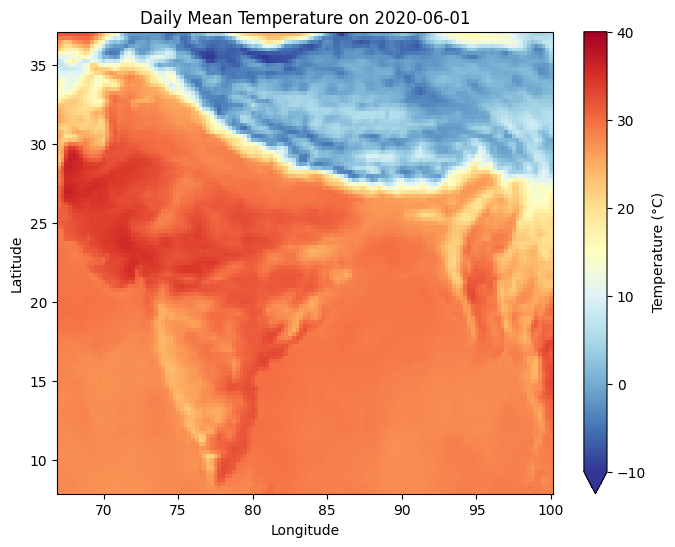

In [8]:
import matplotlib.pyplot as plt

# Plotting the temperature on June 1st, 2020
plt.figure(figsize=(8, 6))
june_daily_mean_celsius.sel(
    time='2020-06-01', method='nearest'
).plot(
    cmap='RdYlBu_r',
    cbar_kwargs={'label': 'Temperature (°C)'},
    vmin=-10,
    vmax=40
)
plt.title('Daily Mean Temperature on 2020-06-01')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

#### Creating an Animation of Temperature over June 2020

We will create an animation to visualize the change in daily mean temperature over the month of June 2020.

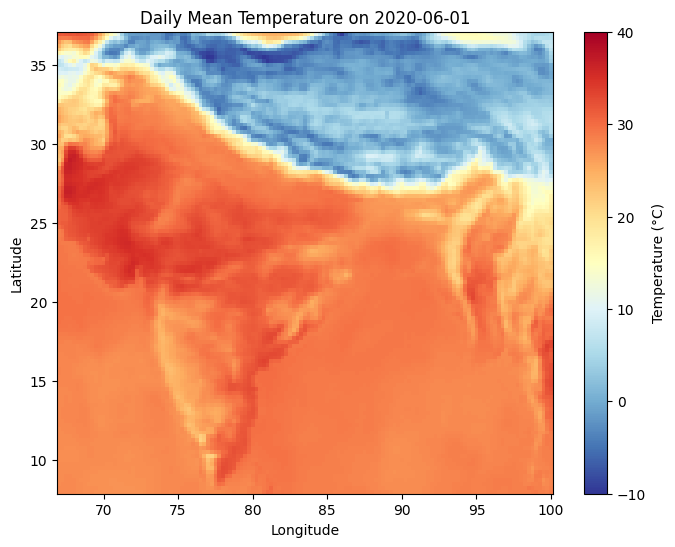

In [9]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Get the list of days in June
days = june_daily_mean_celsius.time.values

# Initialize the plot
data = june_daily_mean_celsius.isel(time=0)
img = ax.pcolormesh(
    data.lon, data.lat, data,
    cmap='RdYlBu_r', vmin=-10, vmax=40
)
plt.colorbar(img, ax=ax, label='Temperature (°C)')
ax.set_title(f'Daily Mean Temperature on {str(days[0])[:10]}')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Update function for the animation
def update(frame):
    ax.clear()
    data = june_daily_mean_celsius.isel(time=frame)
    img = ax.pcolormesh(
        data.lon, data.lat, data,
        cmap='RdYlBu_r', vmin=-10, vmax=40
    )
    ax.set_title(f'Daily Mean Temperature on {str(days[frame])[:10]}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    return img,

# Create the animation
anim = FuncAnimation(
    fig, update, frames=len(days),
    interval=200, blit=False
)

# Display the animation
HTML(anim.to_jshtml())

## Conclusion

In this tutorial, we explored the use of STAC, COGs, and Zarr to handle geospatial data efficiently. We demonstrated how to parse a STAC catalog, read Zarr data, and visualize temperature data over India during the Kharif season. This approach provides a scalable and efficient way to handle large geospatial datasets in cloud environments.